## 다중레이블 분류

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df.iloc[:,0]
df.iloc[0,:]
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [7]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


In [9]:
dblock = DataBlock()

In [10]:
dsets = dblock.datasets(df)

In [11]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [12]:
x,y = dsets.train[0]
x,y

(fname       000656.jpg
 labels             dog
 is_valid          True
 Name: 316, dtype: object,
 fname       000656.jpg
 labels             dog
 is_valid          True
 Name: 316, dtype: object)

In [13]:
x['fname']

'000656.jpg'

### 데이터블록 구성하기

In [14]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005121.jpg', 'dog')

In [15]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('000966.jpg', 'train person')

In [16]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/user/.fastai/data/pascal_2007/train/000224.jpg'),
 ['tvmonitor', 'bottle'])

In [17]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [18]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['chair','diningtable']

In [19]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [20]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

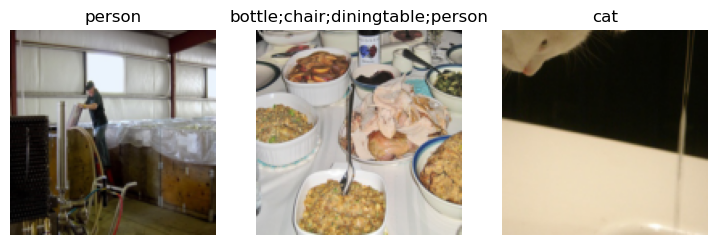

In [21]:
dls.show_batch(nrows=1, ncols=3)

### 이진교차 엔트로피

In [22]:
learn = vision_learner(dls, resnet18)

C:\Users\user\.conda\envs\geopandas\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\.conda\envs\geopandas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [24]:
activs[0]

TensorBase([ 0.0626, -1.3356,  0.8570,  0.3389, -5.1851, -0.7284,  0.3181,
            -0.6116,  0.5952,  0.5967, -2.9521, -1.2567,  1.6657,  2.9825,
             1.7380,  0.0911,  2.1589, -4.4713,  0.0615,  2.8943],
           grad_fn=<AliasBackward0>)

In [25]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [26]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0273, grad_fn=<AliasBackward0>)

In [27]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

In [28]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [29]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [30]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [31]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

C:\Users\user\.conda\envs\geopandas\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.939307,0.690344,0.237151,19:58
1,0.821139,0.564904,0.286255,21:02
2,0.600058,0.206215,0.803546,19:41
3,0.357643,0.125161,0.943347,19:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133952,0.121078,0.942012,23:57
1,0.116487,0.108765,0.950020,24:26
2,0.096555,0.103974,0.953366,24:05


In [32]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10397408157587051,0.9332072138786316]

In [33]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10397408157587051,0.9428285956382751]

In [34]:
preds,targs = learn.get_preds()

In [35]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9566)

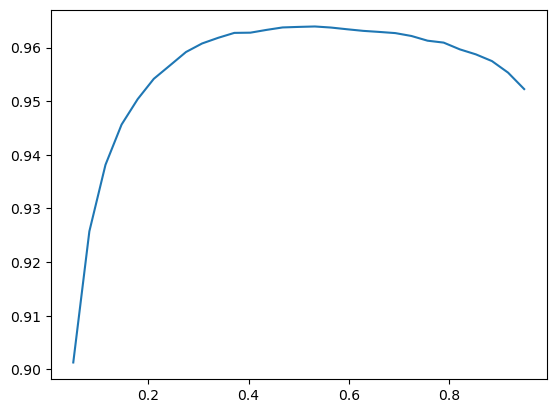

In [36]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## 회귀

In [37]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [38]:
path.ls().sorted()

(#50) [Path('C:/Users/user/.fastai/data/biwi_head_pose/01'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/user/.fastai/data/biwi_head_pose/02'),Path('C:/Users/user/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/user/.fastai/data/biwi_head_pose/03'),Path('C:/Users/user/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/user/.fastai/data/biwi_head_pose/04'),Path('C:/Users/user/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/user/.fastai/data/biwi_head_pose/05'),Path('C:/Users/user/.fastai/data/biwi_head_pose/05.obj')...]

In [39]:
(path/'01').ls().sorted()

(#1000) [Path('C:/Users/user/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [40]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('C:/Users/user/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [41]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

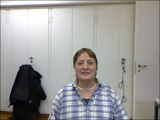

In [42]:
im.to_thumb(160)

In [43]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [44]:
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [45]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

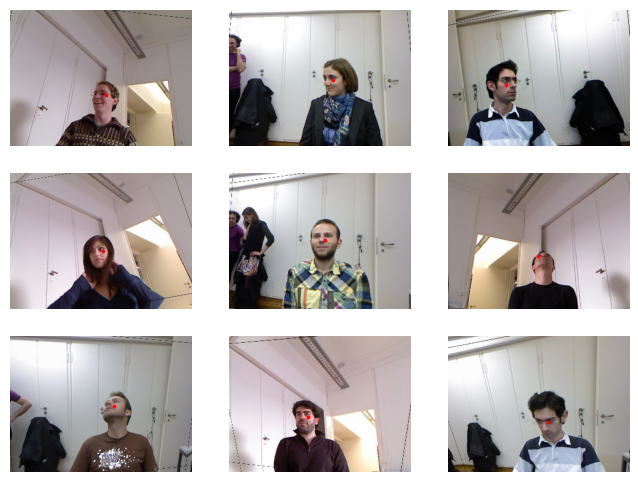

In [46]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [47]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [48]:
yb[0]

TensorPoint([[0.3962, 0.0669]])

### 모델 학습

In [49]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [54]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

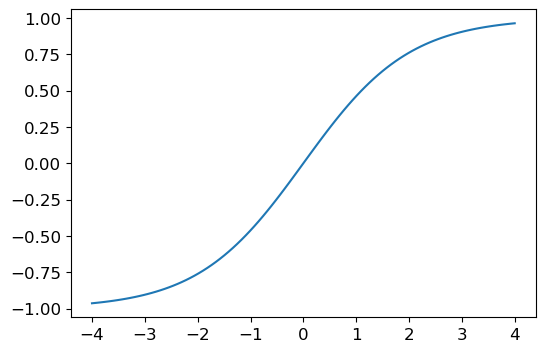

In [55]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [56]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0008317637839354575)

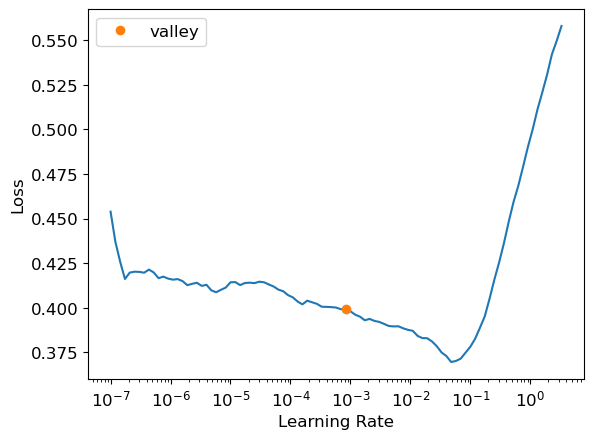

In [57]:
learn.lr_find()

In [58]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047453,0.013347,1:25:48


epoch,train_loss,valid_loss,time
0,0.008377,0.000856,1:58:13
1,0.002876,0.000228,2:13:27
2,0.001565,0.000240,2:22:35


In [59]:
math.sqrt(0.0001)

0.01

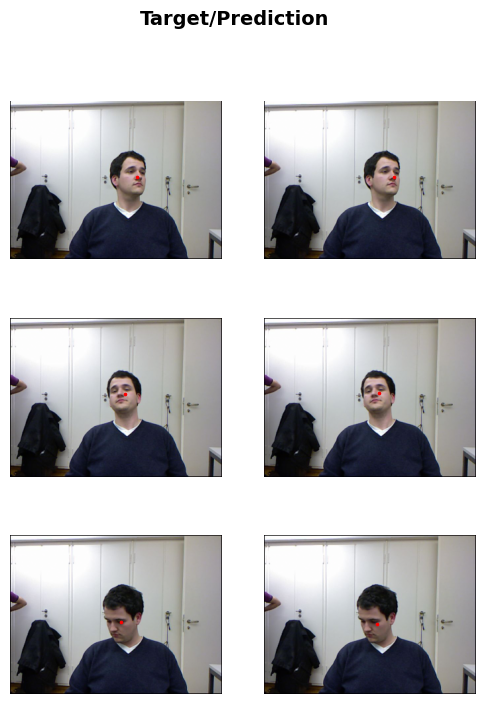

In [60]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))